## **Introduction**

To recap what we have covered so far: In the **first notebook**, we introduced different methods for segmenting an image, such as using thresholds or the Simple Linear Iterative Clustering (SLIC) approach. In the **second notebook**, we continued by exploring how to extract useful attributes from each segment, known as features. These features include metrics like mean intensity per segment, standard deviation, rectangularity, compactness, and more.

In this notebook, we will bring everything together by using the features we've extracted to classify the segments we identified earlier. Specifically, our goal is to create a binary classifier that can determine whether each segment represents a tree in the image.

<img src="https://github.com/mariarodriguezn/obia_tutorials/blob/main/assets/general_workflow.png?raw=true" width="700">




## **Setup**
Please run the cell below. After that, go to **Runtime -> Restart session**, and confirm. Once the session restarts, move on to the next cell **without running this one again**.

In [ ]:
# Check if running on Google Colab
if 'google.colab' in str(get_ipython()):
    import os
    repo_dir = "obia_tutorials"
    marker_file = os.path.join(repo_dir, ".setup_done")

    # Setup the environment only if it hasn't been done already
    if not os.path.exists(marker_file):
        # Clone the repository
        !git clone https://github.com/mariarodriguezn/obia_tutorials.git

        # Install the required packages
        !pip install -r obia_tutorials/requirements.txt

        # Create a marker file to avoid re-running the setup
        with open(marker_file, 'w') as f:
            f.write("Setup completed")

In [ ]:
# imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import rasterio

from scipy import stats
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table, perimeter
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm


## **Image Segmentation**

We will continue working with the same high-resolution image. As a reminder, this image contains four spectral bands: Red, Green, Blue, and Near-Infrared (NIR). Additionally, we will utilize the Normalized Difference Vegetation Index (NDVI) that was calculated from these bands.

For the segmentation process we will again use SLIC algorithm with a compactness value of 0.3 and set the number of superpixels to 3000 as displayed below.

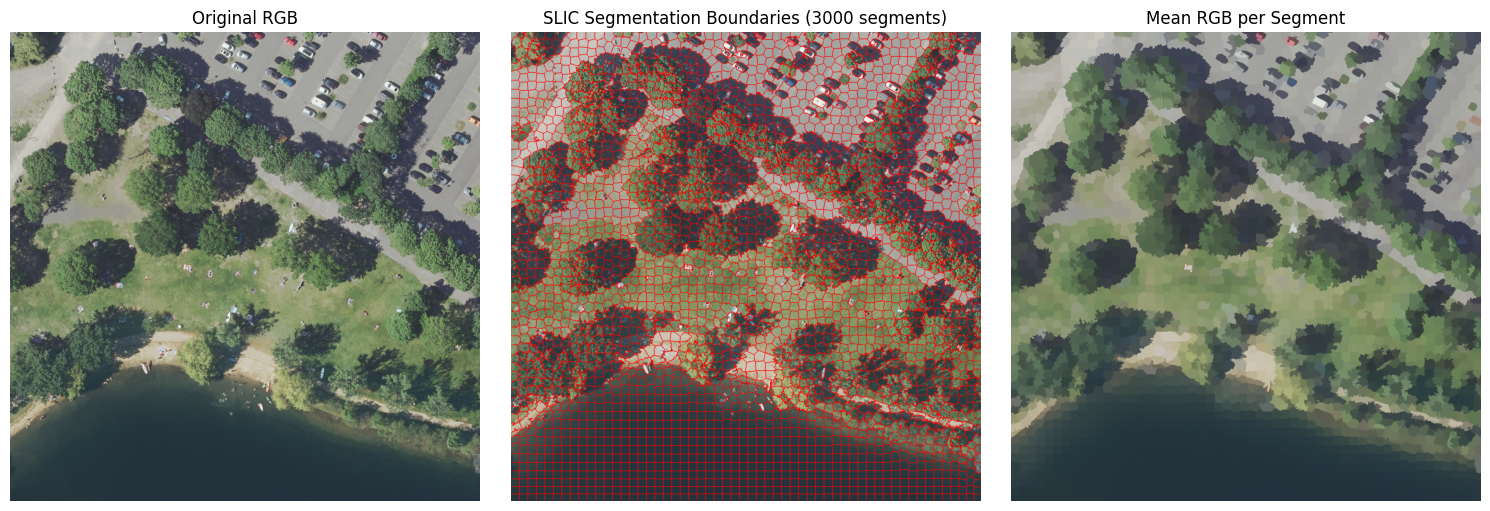

In [ ]:
# File path to the image
img_path = "obia_tutorials/sample_data/ortho_subset_I.tif"

# Read the image and extract the bands
with rasterio.open(img_path) as src:
    # Extract red, green, blue, and NIR bands, normalize to [0, 1]
    bands = src.read([1, 2, 3, 4]).astype(float) / 255
    red, green, blue, nir = bands

# Stack RGB into an array
rgb = np.stack([red, green, blue], axis=-1)

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-6)  # small value added to avoid division by zero

# Stack all bands into an array
image = np.stack([red, green, blue, nir], axis=-1)

# Set the fixed compactness and number of superpixels
compactness = 0.3
n_segments = 3000

# Generate segments using SLIC
segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=1)

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries ({n_segments} segments)")

# Display the mean RGB per segment
axs[2].imshow(label2rgb(segments, rgb, kind='avg'))
axs[2].set_title("Mean RGB per Segment")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()

## **Features Extraction**

As explained in the second notebook, there are multiple features that can be extracted to characterize the segments using `region_props` function from the`skiimage` Python library. In this case, to train our classifier later, we will calculate the following features for each segment :

* **Spectral Features** across different bands (Red, Green, Blue, NIR, and NDVI)
  * Intensity Mean
  * Standard Deviation

* **Shape Features**
  * Rectangularity
  * Compactness
  * Solidity

* **Textural Features**
  * Entropy of NDVI


In [ ]:
# Stack all bands into an array
full_stack_arr = np.stack([red, green, blue, nir, ndvi], axis=-1)

# Define custom features
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    std = np.std(vals)
    return std

def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

def compactness(regionmask):
    return 4*np.pi*regionmask.sum()/(perimeter(regionmask)**2 + 1e-6)  # small value added to avoid division by zero

def entropy_ndvi(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(-1,1))[0]
    return stats.entropy(arr)

# Calculate set of various features for each segment
def calc_all_feats(seg_arr, img_arr):
    spectral_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            intensity_image = img_arr,
            properties = ["label", "intensity_mean"],
            extra_properties=(std,)
        )
    )
    shape_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            properties = ["solidity"],
            extra_properties=(rectangularity, compactness)
        )
    )

    textural_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            intensity_image =img_arr[:, :, -1],  # Use only the NDVI band
            properties = [],
            extra_properties=(entropy_ndvi,)
        )
    )

    all_feats = pd.concat([spectral_feats, shape_feats, textural_feats], axis=1)

    return all_feats

all_feats_df = calc_all_feats(segments, full_stack_arr)
display(all_feats_df)

,label,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4,std-0,std-1,std-2,std-3,std-4,solidity,rectangularity,compactness,entropy_ndvi
0,1,0.604319,0.625089,0.583083,0.655850,0.039661,0.064737,0.062445,0.086558,0.083263,0.071410,0.847934,0.500000,0.491792,2.252299
1,2,0.359322,0.392994,0.320563,0.639866,0.288713,0.094232,0.107423,0.076962,0.103788,0.068792,0.800000,0.572840,0.341122,2.613532
2,3,0.441907,0.489653,0.374884,0.729637,0.253889,0.095153,0.102003,0.070536,0.058184,0.065811,0.808237,0.559715,0.386013,2.550723
3,4,0.234354,0.266893,0.268920,0.568947,0.421836,0.050760,0.054977,0.033114,0.042983,0.059759,0.928571,0.884885,0.627548,2.337086
4,5,0.205337,0.234459,0.260040,0.486482,0.406761,0.044260,0.065769,0.034007,0.083015,0.043664,0.959746,0.801061,0.741152,2.134272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,2953,0.140090,0.206220,0.241319,0.220157,0.222641,0.007511,0.010727,0.011009,0.007021,0.016770,1.000000,1.000000,0.846757,1.316009
2953,2954,0.141707,0.208822,0.243838,0.223340,0.224049,0.007561,0.010474,0.010760,0.006470,0.015958,1.000000,1.000000,0.846757,1.242225
2954,2955,0.143506,0.209567,0.246361,0.222917,0.217008,0.006894,0.010396,0.010581,0.006797,0.014103,0.998325,0.996656,0.843259,1.196127
2955,2956,0.144446,0.210656,0.247117,0.223413,0.215110,0.008707,0.012481,0.013286,0.008106,0.018723,0.969534,0.940870,0.824069,1.400828


## **Image Classification**


Now, using the 14 features calculated above, we we will create a binary classifier to identify the trees in the image using Random Forest Algorithm.

Random Forest is a machine learning algorithm that works by creating multiple decision trees during training. Each tree makes a prediction, and the Random Forest aggregates these predictions to determine the final output. This method helps improve accuracy and reduces the risk of overfitting.

The key stages of this process are:

<img src="https://github.com/mariarodriguezn/obia_tutorials/blob/main/assets/image_classification_workflow.png?raw=true" width="800">






### **Label Image Segments**

For the purpose of this exercise, the sample segments labeled as trees and non-trees are already provided in the following cell. Additionally, a new column called **`class`** is added to the existing DataFrame `all_feats_df`, which contains all the segments along with their corresponding features. This new column indicates the class, with **1 for trees, 0 for non-trees, and -1 for unlabeled segments**.

In [ ]:
# Samples for both classes: trees and non-trees
trees_idxs = [
    1204, 1186, 1134, 1229, 1329, 1201, 1140, 1218, 1351, 962, 830, 886, 926, 1373, 1405, 1517, 1547, 1461, 1526, 1406, 1358, 1460, 1556, 735, 833, 838, 802, 513, 616, 565, 438, 258, 375, 334, 284, 204, 250, 155, 183, 241, 344, 359, 412, 328, 424, 506, 468, 554, 459, 579, 560, 769, 890, 791, 798, 811, 771, 846, 1076, 784, 919, 915, 133, 246, 356, 405, 425, 474, 166, 158, 34, 200, 209, 245, 55, 2003, 1984, 1910, 1813, 1873, 1923, 2296, 2220, 2143, 2113, 2153, 2319, 2275, 2284, 2422, 2451, 2398, 2460, 2455, 2208, 2218, 2199, 2036, 1986, 1924
]

non_trees_idxs = [
    2647, 2653, 2717, 2784, 2110, 2061, 2122, 1988, 1943, 2018, 1861, 1896, 1909, 1900, 1829, 1758, 1719, 1703, 1794, 1812, 1749, 1581, 1580, 1522, 1451, 1438, 1479, 1408, 1511, 1631, 1869, 1811, 1978, 2104, 2187, 2299, 2400, 2732, 2642, 2567, 2348, 2369, 2401, 2281, 1850, 1117, 197, 1002, 872, 216, 432, 418, 357, 382, 419, 336, 295, 351, 460, 644, 708, 800, 902, 1005, 1063, 174, 824, 831, 780, 1291, 1412, 1537, 1497, 1570, 1605, 1491, 1595, 1652, 1768, 1807, 1887, 1898, 1968, 1573, 1540, 1536, 1439, 1388, 1694, 2640
]

# Initialize the 'class' column in all_feats_df to -1 (for unlabeled segments)
all_feats_df['class'] = -1

# Update the 'class' column for tree segments (label 1)
all_feats_df.loc[all_feats_df['label'].isin(trees_idxs), 'class'] = 1

# Update the 'class' column for non-tree segments (label 0)
all_feats_df.loc[all_feats_df['label'].isin(non_trees_idxs), 'class'] = 0

# Display the updated DataFrame
all_feats_df = all_feats_df.rename(columns={'label': 'indx'})
display(all_feats_df)


,indx,intensity_mean-0,intensity_mean-1,intensity_mean-2,intensity_mean-3,intensity_mean-4,std-0,std-1,std-2,std-3,std-4,solidity,rectangularity,compactness,entropy_ndvi,class
0,1,0.604319,0.625089,0.583083,0.655850,0.039661,0.064737,0.062445,0.086558,0.083263,0.071410,0.847934,0.500000,0.491792,2.252299,-1
1,2,0.359322,0.392994,0.320563,0.639866,0.288713,0.094232,0.107423,0.076962,0.103788,0.068792,0.800000,0.572840,0.341122,2.613532,-1
2,3,0.441907,0.489653,0.374884,0.729637,0.253889,0.095153,0.102003,0.070536,0.058184,0.065811,0.808237,0.559715,0.386013,2.550723,-1
3,4,0.234354,0.266893,0.268920,0.568947,0.421836,0.050760,0.054977,0.033114,0.042983,0.059759,0.928571,0.884885,0.627548,2.337086,-1
4,5,0.205337,0.234459,0.260040,0.486482,0.406761,0.044260,0.065769,0.034007,0.083015,0.043664,0.959746,0.801061,0.741152,2.134272,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,2953,0.140090,0.206220,0.241319,0.220157,0.222641,0.007511,0.010727,0.011009,0.007021,0.016770,1.000000,1.000000,0.846757,1.316009,-1
2953,2954,0.141707,0.208822,0.243838,0.223340,0.224049,0.007561,0.010474,0.010760,0.006470,0.015958,1.000000,1.000000,0.846757,1.242225,-1
2954,2955,0.143506,0.209567,0.246361,0.222917,0.217008,0.006894,0.010396,0.010581,0.006797,0.014103,0.998325,0.996656,0.843259,1.196127,-1
2955,2956,0.144446,0.210656,0.247117,0.223413,0.215110,0.008707,0.012481,0.013286,0.008106,0.018723,0.969534,0.940870,0.824069,1.400828,-1


To better understand the location of the given labeled samples, they can be displayed displayed based on the class.

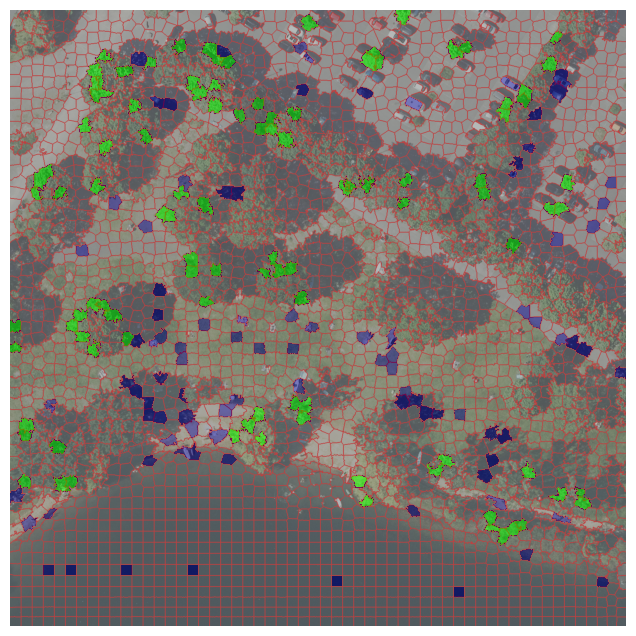

In [ ]:
# Map the labeled segments onto the original segmented image
mapped_samples = map_array(
    segments,
    np.array(all_feats_df["indx"]),
    np.array(all_feats_df["class"])
)

# Define the colors:
# [-1] = undefined segments (grey), [0] = non-trees (dark blue), [1] = trees (green)
background_c, others_c, trees_c = '#7f8282', '#00008b', '#00FF00'
binary_cmap = mcolors.ListedColormap([background_c, others_c, trees_c])

# Display the original image with segment boundaries
plt.figure(figsize=(12, 8))
plt.imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="outer"))

# Overlay the labeled segments with the defined colors
plt.imshow(mapped_samples, cmap=binary_cmap, alpha=0.5)

# Turn off the axis for a cleaner look
plt.axis("off")

# Show the plot
plt.show()

As evidenced in the image above, the samples adhere to several key principles when selecting or creating training data for a classification model

*  **Homogeneity**: Segments are chosen to be internally consistent, representing a single class to minimize noise in the training data.
*   **Representativeness**: The samples capture the full range of variability within each class, including different textures, colors, and shapes.
*   **Spatial Distribution**: The samples are distributed across the image to cover different areas, preventing the model from overfitting to specific regions.

*   **Class Balance**: There is an effort to maintain a balance between different classes to prevent bias in the model and improve overall accuracy.






### **Train Random Forest Classifier**

In this stage, we start by selecting only the image segments that we have labeled as "tree" or "non-tree," ignoring any segments without labels. We then split the data into two parts: the features columns (which are the characteristics we measured from each segment) and the class column (which tells us if the segment is a tree or not).

Next, we train a Random Forest model, which as mentioned is a type of machine learning method that creates many decision trees to improve accuracy. We set it to create 100 trees and use the Out-of-Bag (OOB) score to check how well the model might work on new, unseen data. The OOB score is a built-in way to test the model's accuracy without needing a separate test set, making it a practical way to assess how well the model is likely to perform.

In [ ]:
# Filter out the labeled samples
labeled_segments_df = all_feats_df[all_feats_df['class'] != -1]

# Separate features (X) and class label (y)
X = labeled_segments_df.drop(columns=['indx', 'class'])
y = labeled_segments_df['class']

# Train the Random Forest Classifier using the entire dataset
clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
clf.fit(X, y)

# Evaluate the model using OOB score
print("OOB Score:", clf.oob_score_)

OOB Score: 0.9210526315789473


The OOB score ranges from 0 to 1, where a score of 0 indicates that the model performs no better than random guessing, and a score of 1 indicates perfect accuracy. An OOB score of approximately 0.92 suggests that the Random Forest model correctly classifies 92% of the segments as either 'tree' or 'non-tree' based on the provided features. This high OOB score indicates that the model has a strong ability to generalize to new, unseen data, effectively distinguishing between 'tree' and 'non-tree' segments."


### **Test the Classifier**

Now, to further evaluate the classifier, we apply the trained classifier to the **unlabeled** segments. This step is fundamental to determine how well the classifier can generalize beyond the labeled training data and make accurate predictions on new, unseen segments.

In [ ]:
# Filter out the unlabeled segments
unlabeled_segments_df = all_feats_df[all_feats_df['class'] == -1]

# Separate features (X) for the unlabeled segments
X = unlabeled_segments_df.drop(columns=['indx', 'class'])

# Predict the class labels for the unlabeled segments
predictions = clf.predict(X)

# Update the original dataframe with the predictions
all_feats_df.loc[all_feats_df['class'] == -1, 'class'] = predictions

### **Interpret the results**

Finally, to actually analyze the resulting prediction on the unlabeled segments, below the results are plot.

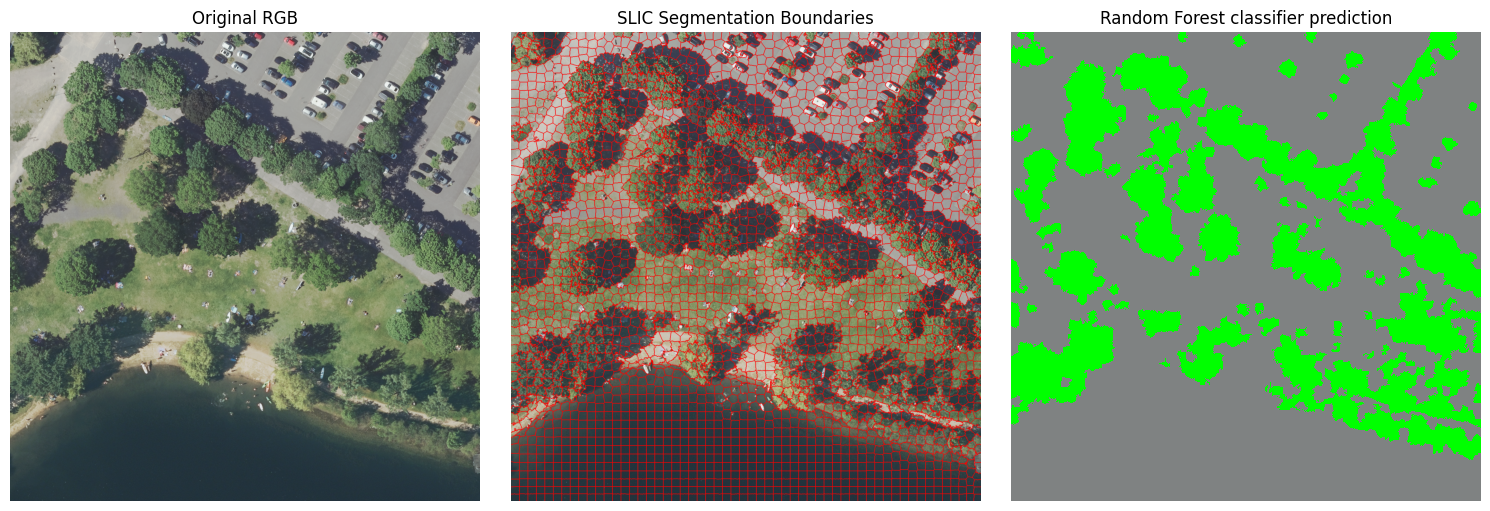

In [ ]:
#  Map the predictions onto the original segmented image
mapped_predictions = map_array(
    segments,
    np.array(all_feats_df["indx"]),
    np.array(all_feats_df["class"]))

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries")

# Display the prediction result
axs[2].imshow(mapped_predictions, cmap=binary_cmap, interpolation="nearest")
axs[2].set_title("Random Forest classifier prediction")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()

As you can see, the model's predictions are far from perfect but not too bad for a model that has been trained on just a handful of samples and features (less than 200 and 14, respectively). Note also that a pixel-wise classification would never achieve such accuracies and that deep learning approaches are more accurate but usually need hundreds or thousands of training images.

## **Conclusion & Further thoughts**

This tutorial provided a simple example of how an image can be segmented, its features extracted, and then classified using a random forest algorithm.

Future directions for exploration could include scaling up these experiments by applying machine learning models like random forests to larger and more diverse datasets. A key area of interest might be identifying the smallest, most computationally efficient set of features that still achieve high accuracy for specific tasks. This is particularly relevant in the context of the growing prominence of deep learning models. Although training deep learning models requires large amounts of data and can be time-consuming, their inference time (meaning the time it takes to apply the model to new, unseen data) is typically very fast.